In [3]:
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import zscore
from natsort import natsorted

from __init__ import *
import snmcseq_utils
from snmcseq_utils import cd
from snmcseq_utils import create_logger
from snmcseq_utils import plot_tsne_labels 
from CEMBA_run_tsne import run_tsne
from CEMBA_clustering_louvain_jaccard import louvain_jaccard
from CEMBA_update_mysql import connect_sql 

In [4]:
import importlib
importlib.reload(snmcseq_utils)
# import CEMBA_clustering_louvain_jaccard
# importlib.reload(CEMBA_clustering_louvain_jaccard)
# from CEMBA_clustering_louvain_jaccard import louvain_jaccard

# import CEMBA_run_tsne
# importlib.reload(CEMBA_run_tsne)
# from CEMBA_run_tsne import run_tsne

log = create_logger()
ens = 'Ens10'
context = 'CH'

# snmCSeq preprocessing

In [5]:
def get_mcc(df, base_call_cutoff=100, sufficient_coverage_fraction=1):
    """Get mcc matrix from mc_c matrix (filtering out low coverage gene or bins)
    """
    logging.info('Getting mcc matrix from mc and c') 
    logging.info('base_call_cutoff={}, sufficient_coverage_fraction={}'.format(
                base_call_cutoff, sufficient_coverage_fraction))
    
    df_c = df.filter(regex="_c$")
    df_c.columns = [col[:-len('_c')] for col in df_c.columns] 
    df_mc = df.filter(regex="_mc$")
    df_mc.columns = [col[:-len('_mc')] for col in df_mc.columns] 
    # a gene is sufficiently covered in % of cells 
    condition = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*(df.shape[1])/2.0 

    logging.info("Matrix size before pruning... "+ str(df.shape))
    logging.info("Matrix size after pruning... "+ str(df.loc[condition].shape))
    
    # get mcc matrix with kept bins and nan values for low coverage sites
    df_c_nan = df_c.copy()
    df_c_nan[df_c < base_call_cutoff] = np.nan
    df_mcc = df_mc.loc[condition]/df_c_nan.loc[condition]
    logging.info(df_mcc.shape)

    # imputation (missing value -> mean value of all cells)
    logging.info('Imputing data... (No effect if sufficient_coverage_fraction=1)')
    means = df_mcc.mean(axis=1)
    fill_value = pd.DataFrame({col: means for col in df_mcc.columns})
    df_mcc.fillna(fill_value, inplace=True)
    
    # add suffix
    df_mcc.columns = df_mcc.columns.values + '_mcc'
    
    return df_mcc


In [7]:
def gene_id_to_name(gene_id, df_genes):
    """df_genes
    """
    return df_genes.loc[gene_id, 'gene_name']


In [8]:
# get gene*cell matrix (methylation)
fm = os.path.join(PATH_ENSEMBLES, ens, 'gene_level', 'genebody_m{}_{}.tsv.bgz'.format(context, ens))
df_m = pd.read_table(fm, index_col='gene_id', compression='gzip')
print(df_m.shape)
df_m.head()

KeyboardInterrupt: 

In [9]:
# get tsne and clustering (methylation)
database = DATABASE
engine = connect_sql(database) 
tsne_type = 'mCHmCG_ndim2_perp30'
cluster_type = 'mCHmCG_lv_npc50_k30'
sql = """SELECT cell_name, tsne_x_{}, tsne_y_{}, cluster_{}, annotation_{}
        FROM {} 
        JOIN cells ON cells.cell_id = {}.cell_id""".format(tsne_type, tsne_type, cluster_type, cluster_type, 
                                                       ens, ens)

df_info_m = pd.read_sql(sql, engine, index_col='cell_name')
print(df_info_m.shape)
df_info_m.head()

(5352, 4)


,tsne_x_mCHmCG_ndim2_perp30,tsne_y_mCHmCG_ndim2_perp30,cluster_mCHmCG_lv_npc50_k30,annotation_mCHmCG_lv_npc50_k30
cell_name,,,,
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD001_indexed,-17.9718,-45.7888,3,mL2/3
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD002_indexed,-72.3889,-32.8037,4,mL5-1
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD004_indexed,34.1628,-49.8856,1,mL4
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD007_indexed,-1.2001,-15.6003,2,mL2/3
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD008_indexed,34.9378,-48.1781,1,mL4


In [10]:
# gene annotation
sql = """SELECT * FROM genes"""
df_genes = pd.read_sql(sql, engine, index_col='gene_id')
print(df_genes.shape)
df_genes.head()

(53379, 6)


,gene_name,chr,start,end,strand,gene_type
gene_id,,,,,,
ENSMUSG00000000001.4,Gnai3,chr3,108107280,108146146,-,protein_coding
ENSMUSG00000000003.15,Pbsn,chrX,77837901,77853623,-,protein_coding
ENSMUSG00000000028.14,Cdc45,chr16,18780447,18811987,-,protein_coding
ENSMUSG00000000031.16,H19,chr7,142575529,142578143,-,lincRNA
ENSMUSG00000000037.16,Scml2,chrX,161117193,161258213,+,protein_coding


In [12]:
# cluster and annotation
df_clst_annot_m = df_info_m[['cluster_'+cluster_type, 'annotation_'+cluster_type]].groupby('cluster_'+cluster_type).first().fillna('Glia')
df_clst_annot_m.head()

,annotation_mCHmCG_lv_npc50_k30
cluster_mCHmCG_lv_npc50_k30,
1,mL4
2,mL2/3
3,mL2/3
4,mL5-1
5,mL6-2


In [13]:
# get gene*cluster matrix (methylation)
clusters_mc_c = snmcseq_utils.get_cluster_mc_c(ens, context, genome_regions='genebody', 
                     cluster_col='cluster_'+cluster_type, database=database)
clusters_mcc = get_mcc(clusters_mc_c, base_call_cutoff=1000, sufficient_coverage_fraction=1)
clusters_mcc.columns = [col[:-len('_mcc')] 
                        + '_' + df_clst_annot_m.loc[int(col[len('cluster_'):-len('_mcc')]), 'annotation_'+cluster_type]
                        for col in clusters_mcc.columns]

clusters_mcc.index = [gene_id_to_name(gene_id, df_genes) for gene_id in clusters_mcc.index]

print(clusters_mcc.shape)
clusters_mcc.head()

/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
03/20/2018 01:41:33 PM Found gene*cell matrix in /cndd/Public_Datasets/CEMBA/snmCSeq/Ensembles/Ens10/gene_level/genebody_mCH_Ens10.tsv.bgz
03/20/2018 01:44:21 PM Output shape: (51772, 52)
03/20/2018 01:44:21 PM Getting mcc matrix from mc and c
03/20/2018 01:44:21 PM base_call_cutoff=1000, sufficient_coverage_fraction=1
03/20/2018 01:44:21 PM Matrix size before pruning... (51772, 52)
03/20/2018 01:44:21 PM Matrix size after pruning... (29330, 52)
03/20/2018 01:44:21 PM (29330, 26)
03/20/2018 01:44:21 PM Imputing data... (No effect if sufficient_coverage_fraction=1)


(29330, 26)


,cluster_1_mL4,cluster_2_mL2/3,cluster_3_mL2/3,cluster_4_mL5-1,cluster_5_mL6-2,cluster_6_mL5-1,cluster_7_mDL-2,cluster_8_mDL-2,cluster_9_mSst-1,cluster_10_mL5-2,...,cluster_17_mNdnf-2,cluster_18_Glia,cluster_19_mL4,cluster_20_mL6-2,cluster_21_Glia,cluster_22_mL6-2,cluster_23_Glia,cluster_24_mPv,cluster_25_mSst-1,cluster_26_mDL-3
Xkr4,0.013761,0.016505,0.017940,0.014267,0.011451,0.013052,0.014645,0.014163,0.012715,0.029372,...,0.012942,0.018790,0.013953,0.012073,0.007599,0.013786,0.007367,0.013978,0.014282,0.018744
Gm37180,0.015110,0.027708,0.020891,0.016352,0.013310,0.013931,0.018120,0.015383,0.011690,0.036102,...,0.010172,0.058044,0.020369,0.013772,0.009883,0.014879,0.008289,0.009768,0.012212,0.025572
Gm1992,0.015230,0.015997,0.017819,0.013743,0.011584,0.013527,0.015129,0.013857,0.012876,0.032229,...,0.013328,0.022315,0.014776,0.012590,0.007261,0.014232,0.006640,0.014186,0.014519,0.019670
Gm38148,0.010090,0.011220,0.011339,0.008410,0.009044,0.010439,0.010316,0.009531,0.008996,0.016012,...,0.009347,0.009426,0.008258,0.007376,0.008415,0.008192,0.008674,0.010904,0.012920,0.008253
Gm19938,0.016623,0.021030,0.023130,0.016281,0.012556,0.014772,0.018853,0.015408,0.011755,0.036507,...,0.012110,0.016139,0.014851,0.011783,0.007261,0.014791,0.007542,0.013404,0.014403,0.025684


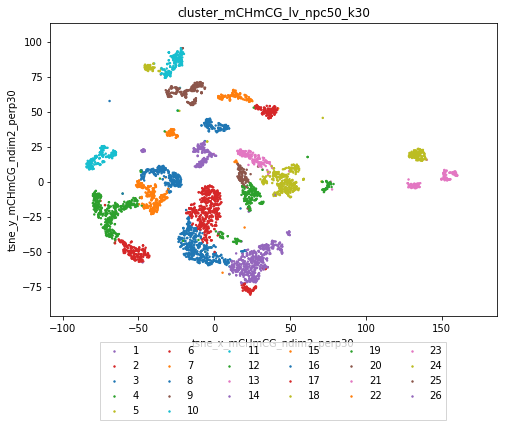

In [236]:
# plot clustering (methylation)
plot_tsne_labels(df_info_m, 
                 tx='tsne_x_'+tsne_type, 
                 ty='tsne_y_'+tsne_type, 
                 tc='cluster_'+cluster_type, 
                 legend_mode=1, s=2) 

# ATAC preprocessing

In [ ]:
# get gene*cell matrix (ATAC)

f = '/cndd/Public_Datasets/CEMBA/snATACSeq/Datasets/CEMBA_3C_171206/CEMBA_3C_171206_merged.gene10kb.counts.tsv'
df = pd.read_table(f)
# remove chr
df['chr'] = [chrom[len('chr'):] for chrom in df['chr']]
# set index
df = df.set_index(['chr', 'start'])
print(df.shape)
df.head()


In [101]:
# tsne 
ti = time.time()
df_tsne = run_tsne(df, perp=50, n_pc=50, verbose=3, n_iter=2000)
print(df_tsne.shape)
df_tsne.head()

output = '/cndd/fangming/integration/tsne_ATAC_test.tsv'
df_tsne.to_csv(output, sep='\t', header=True, index=True, na_rep='NA')
logging.info(time.time() - ti)

03/19/2018 06:10:26 PM Running tsne: 50 PC, 50 perp, 2 dim.
Input shape: (25475, 9298)


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 9298 samples in 0.015s...
[t-SNE] Computed neighbors for 9298 samples in 2.372s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9298
[t-SNE] Computed conditional probabilities for sample 2000 / 9298
[t-SNE] Computed conditional probabilities for sample 3000 / 9298
[t-SNE] Computed conditional probabilities for sample 4000 / 9298
[t-SNE] Computed conditional probabilities for sample 5000 / 9298
[t-SNE] Computed conditional probabilities for sample 6000 / 9298
[t-SNE] Computed conditional probabilities for sample 7000 / 9298
[t-SNE] Computed conditional probabilities for sample 8000 / 9298
[t-SNE] Computed conditional probabilities for sample 9000 / 9298
[t-SNE] Computed conditional probabilities for sample 9298 / 9298
[t-SNE] Mean sigma: 4.016747
[t-SNE] Computed conditional probabilities in 0.917s
[t-SNE] Iteration 50: error = 70.7251053, gradient norm = 0.0186705 (50 iterations in 12.416s)
[t-SNE] Iteration 100

03/19/2018 06:19:37 PM Done with tSNE. running time: 550.8495242595673 seconds.
03/19/2018 06:19:37 PM 550.8861038684845


[t-SNE] Iteration 2000: error = 1.4004774, gradient norm = 0.0000390 (50 iterations in 13.681s)
[t-SNE] Error after 2000 iterations: 1.400477
(9298, 2)


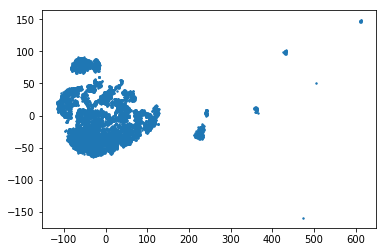

In [109]:
# plot tsne
fig, ax = plt.subplots()
ax.scatter(df_tsne['tsne_x'], df_tsne['tsne_y'], s=2)
# ax.set_xlim([-200, 200])
# ax.set_ylim([-100, 100])
plt.show()

In [12]:
# clustering
df_clst, clst_summary = louvain_jaccard(df, n_pc=50, k=30, sub_ncells=None, output_file=None, sample_column_suffix=None)
# output = '/cndd/fangming/integration/clustering_ATAC_test.tsv'
# df_clst.to_csv(output, sep='\t', header=True, index=True, na_rep='NA')
print(df_clst.shape)
df_clst.head()

03/19/2018 05:09:32 PM Begin louvain jaccard clustering
Input shape (n_obs, n_features): (9298, 25475)
03/19/2018 05:10:19 PM clustering summary: OrderedDict([('n_cells', 9298), ('k', 30), ('n_pc', 50), ('nclst', 23), ('time_clst', 7.556684732437134), ('time', 46.58204984664917)])


(9298, 1)


,cluster_ID
sample,
AGCGATAGAACCAGGTAAGAGATGTATAGCCT,cluster_5
AGCGATAGAACCAGGTAATGACGTCAGGACGT,cluster_5
AGCGATAGAACCAGGTAGGATAACATAGAGGC,cluster_19
AGCGATAGAACCAGGTATAGCCTTAGGCGAAG,cluster_10
AGCGATAGAACCAGGTATAGCCTTATAGAGGC,cluster_4


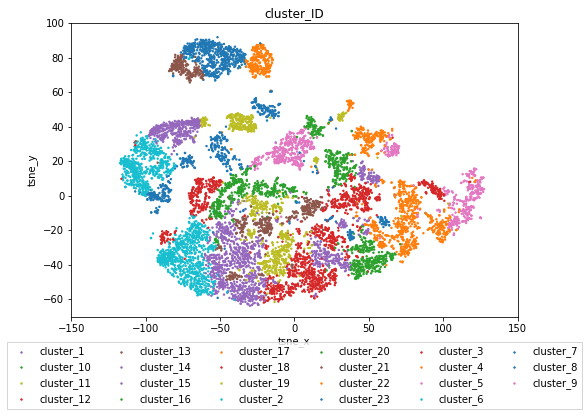

In [110]:
# plot clustering
df_info = pd.merge(df_tsne, df_clst, left_index=True, right_index=True)
plot_tsne_labels(df_info, tc='cluster_ID', legend_mode=1, s=2, 
                 t_xlim=[-150, 150], t_ylim=[-70, 100]
                )

In [14]:
f = '/cndd/fangming/integration/clustering_ATAC_test.tsv'
df_clst_atac2 = pd.read_table(f, index_col='sample')
df_clst_atac2.head()

,cluster_ID
sample,
AGCGATAGAACCAGGTAAGAGATGTATAGCCT,cluster_5
AGCGATAGAACCAGGTAATGACGTCAGGACGT,cluster_5
AGCGATAGAACCAGGTAGGATAACATAGAGGC,cluster_19
AGCGATAGAACCAGGTATAGCCTTAGGCGAAG,cluster_10
AGCGATAGAACCAGGTATAGCCTTATAGAGGC,cluster_4


# ATAC From Rongxin

In [17]:
with cd('/cndd/Public_Datasets/CEMBA/snATACSeq/MiniBrain_fromRongxin'):
    df_clst_atac = pd.read_table('XW45_cluster.txt', header=None, names=['sample', 'cluster_ID'], index_col='sample')
    df_tsne_atac = pd.read_table('XW45_tsne.txt', header=None, names=['sample', 'tsne_x', 'tsne_y'], index_col='sample')
#     df_atac = pd.read_table('XW45_gene.txt.gz')
print(df_clst_atac.shape)
print(df_tsne_atac.shape)
df_clst_atac.head()
df_tsne_atac.head()

(8567, 1)
(8567, 2)


,tsne_x,tsne_y
sample,,
AGCGATAGAACCAGGTAAGAGATGTATAGCCT,-9.268252,-26.684774
AGCGATAGAACCAGGTAATGACGTCAGGACGT,4.436012,26.133310
AGCGATAGAACCAGGTAGGATAACATAGAGGC,-18.538379,18.408741
AGCGATAGAACCAGGTATAGCCTTAGGCGAAG,-5.263620,-22.532956
AGCGATAGAACCAGGTATAGCCTTATAGAGGC,6.972201,-8.754007


In [18]:
with cd('/cndd/Public_Datasets/CEMBA/snATACSeq/MiniBrain_fromRongxin'):
    df_atac = pd.read_table('XW45_gene.txt.gz')
df_atac = df_atac.T
print(df_atac.shape)
df_atac.head()

(8567, 24848)


,Xkr4,Ncaph2,Eif4enif1,Rgr,Mapkapk2,Mrpl15,Myoz2,C1qtnf7,Slc39a14,Gal,...,Klrd1,4933406J09Rik,Ubl5,Zfp367,Cetn3,Sgtb,Gm13427,Lbx2,E130101E03Rik,Gm10646
AGCGATAGAACCAGGTAAGAGATGTATAGCCT,2.3293,0.7072,0.5953,0.5147,0.8165,0.6589,0.0000,0.0312,0.5651,0.0000,...,0.0196,0.2081,1.0442,0.9404,0.5659,1.2015,0.3438,1.5526,0.0,0.0
AGCGATAGAACCAGGTAATGACGTCAGGACGT,0.9921,0.8949,0.4285,0.2169,0.7324,0.6797,0.0694,0.1585,1.0208,0.2244,...,0.0589,0.1850,0.7539,0.3263,0.6810,0.9659,0.1309,0.6814,0.0,0.0
AGCGATAGAACCAGGTAGGATAACATAGAGGC,0.0740,0.4215,2.9547,0.4826,0.7347,0.8830,0.0000,0.0000,1.4510,0.0000,...,0.0000,0.2286,0.4955,0.8938,0.2441,0.1228,0.0000,0.4655,0.0,0.0
AGCGATAGAACCAGGTATAGCCTTAGGCGAAG,1.6337,0.5603,0.5595,0.1568,0.6391,0.4809,0.0257,0.0000,0.6559,0.0240,...,0.0000,0.0410,0.8490,0.7608,0.5826,1.3491,0.1985,0.4072,0.0,0.0
AGCGATAGAACCAGGTATAGCCTTATAGAGGC,1.1935,0.4907,0.3434,0.0824,1.1717,0.8399,0.0000,0.2094,0.9080,0.0183,...,0.0000,0.2754,0.6066,0.4749,1.0178,1.9077,0.0400,0.8908,0.0,0.0


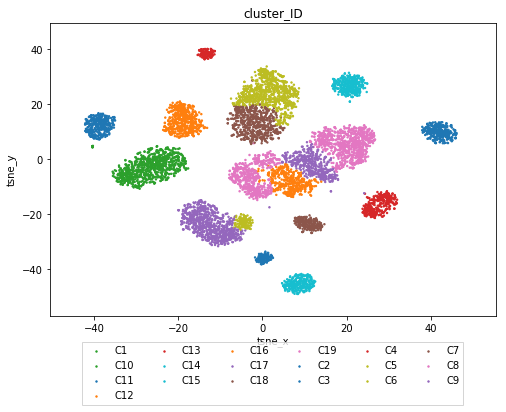

In [20]:
# plot clustering
df_info = pd.merge(df_tsne_atac, df_clst_atac, left_index=True, right_index=True)
plot_tsne_labels(df_info, tc='cluster_ID', legend_mode=1, s=2, 
#                  t_xlim=[-150, 150], t_ylim=[-70, 100]
                )

# Cluster-wise features 

In [29]:
df_clst = df_clst_atac2

print(df_atac.shape)
df_atac.head()

(24848, 8567)


,AGCGATAGAACCAGGTAAGAGATGTATAGCCT,AGCGATAGAACCAGGTAATGACGTCAGGACGT,AGCGATAGAACCAGGTAGGATAACATAGAGGC,AGCGATAGAACCAGGTATAGCCTTAGGCGAAG,AGCGATAGAACCAGGTATAGCCTTATAGAGGC,AGCGATAGAACCAGGTATAGCCTTGTACTGAC,AGCGATAGAACCAGGTATTCGTTGTAATCTTA,AGCGATAGAACCAGGTATTCGTTGTATAGCCT,AGCGATAGAACCAGGTGAAGTATGAGGCGAAG,AGCGATAGAACCAGGTGAAGTATGTATAGCCT,...,TCTCGCGCTTAGCCTCTTGGAAGTATAGAGGC,TCTCGCGCTTCCATCCAAGAGATGAGGCGAAG,TCTCGCGCTTCCATCCAAGAGATGGGCTCTGA,TCTCGCGCTTCCATCCATAGCCTTCCTATCCT,TCTCGCGCTTCCATCCATAGCCTTGGCTCTGA,TCTCGCGCTTCCATCCGGTTAGACCCTATCCT,TCTCGCGCTTCCATCCGGTTAGACGGCTCTGA,TCTCGCGCTTCCATCCTCCGGTAACAGGACGT,TCTCGCGCTTCCATCCTTGGAAGTCCTATCCT,TCTCGCGCTTCCATCCTTGGAAGTTATAGCCT
Xkr4,2.3293,0.9921,0.0740,1.6337,1.1935,1.3900,0.0000,1.5156,1.7755,1.0137,...,1.1744,1.2613,0.8783,1.1268,1.2383,2.0354,0.5448,1.4776,0.8248,1.5198
Ncaph2,0.7072,0.8949,0.4215,0.5603,0.4907,0.6041,1.3469,0.4354,1.2734,0.7676,...,1.2276,1.6495,1.0536,0.6606,0.4002,0.8459,0.5310,0.3135,0.5910,1.4047
Eif4enif1,0.5953,0.4285,2.9547,0.5595,0.3434,0.4247,2.5039,0.6048,0.8982,0.1843,...,0.6268,0.4233,0.0580,0.6102,0.4689,0.7383,0.3384,0.5968,0.3255,0.6695
Rgr,0.5147,0.2169,0.4826,0.1568,0.0824,0.1683,0.4756,0.4450,0.6172,0.1623,...,0.0668,0.0668,0.3163,1.0814,0.2927,0.4611,0.8932,1.2631,0.1776,0.1806
Mapkapk2,0.8165,0.7324,0.7347,0.6391,1.1717,1.1908,1.0460,1.5550,0.7866,0.5246,...,0.5236,0.8667,0.3547,0.7838,1.0622,0.6283,0.5235,2.6980,0.5169,1.3208


In [32]:
# get gene*cluster matrix 

clusters_atac = pd.DataFrame() 
for label, df_sub in df_clst.groupby('cluster_ID'):
    samples = df_sub.index.values
    samples = [sample for sample in samples if sample in df_atac.columns.tolist()]
    clusters_atac[label] = df_atac[samples].mean(axis=1)

logging.info("Output shape: {}".format(clusters_atac.shape))
# reorder by natural sort
clusters_atac = clusters_atac[natsorted(clusters_atac.columns)]
clusters_atac.head()

03/20/2018 01:56:53 PM Output shape: (24848, 23)


,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,...,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18,cluster_19,cluster_20,cluster_21,cluster_22,cluster_23
Xkr4,1.247682,1.101717,1.232174,1.315051,1.242254,0.380709,2.644746,0.636539,1.612637,1.510973,...,0.490135,1.720423,1.225857,2.316656,1.562588,0.423710,1.239144,2.082978,1.416725,0.769865
Ncaph2,0.649876,0.662774,0.570218,0.565506,0.590468,1.012973,0.515174,1.043672,1.008821,0.738278,...,1.091267,0.486284,0.582205,1.252363,0.942553,0.661520,0.850999,0.124595,0.872335,0.875796
Eif4enif1,0.454664,0.426557,0.485846,0.547738,0.502122,2.023850,0.480093,1.752314,0.449737,0.477949,...,1.457827,0.655787,0.528818,0.877840,0.484398,2.313132,0.439978,0.198627,0.390798,0.205424
Rgr,0.388438,0.395726,0.304401,0.327561,0.315283,0.421117,0.216568,0.678136,0.406171,0.419071,...,0.249916,0.507329,0.268440,0.318896,0.436760,0.376605,0.432594,0.049945,0.489819,0.270818
Mapkapk2,1.091767,0.926763,1.089648,1.154046,0.909846,1.568080,0.267956,1.658167,0.697904,0.870387,...,0.763121,1.347219,1.014206,0.495123,0.630945,0.912359,0.594315,0.142163,0.682394,0.383527


In [53]:
# correlation 
clusters_atac = clusters_atac[~clusters_atac.index.duplicated(keep='first')]
clusters_mcc = clusters_mcc[~clusters_mcc.index.duplicated(keep='first')]
# index_both = clusters_atac.index.intersection(clusters_mcc.index)
# print(len(index_both))

data_atac = clusters_atac.rank(pct=True)
data_atac.columns = ['atac_'+col.strip('cluster_') for col in data_atac.columns]
data_mcc = clusters_mcc.rank(pct=True)
data_mcc.columns = ['methyl_'+col.strip('cluster_') for col in data_mcc.columns]

top_genes_atac = data_atac.std(axis=1).sort_values(ascending=False).head(10000)
top_genes_mcc = data_mcc.std(axis=1).sort_values(ascending=False).head(10000)
index_both = top_genes_atac.index.intersection(top_genes_mcc.index)
print(len(index_both))

data_atac = data_atac.loc[index_both, :]
data_mcc = data_mcc.loc[index_both, :]

nclst_atac = data_atac.shape[1]
nclst_mcc = data_mcc.shape[1]
print(data_atac.shape)
print(data_mcc.shape)

3086
(3086, 23)
(3086, 26)


In [54]:
corr = np.corrcoef(np.concatenate((data_atac.values, data_mcc.values), axis=1).T)
print(corr.shape)

(49, 49)


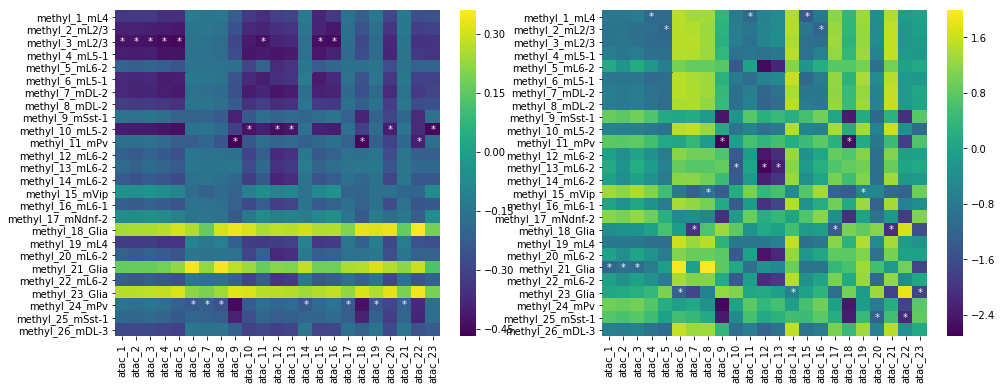

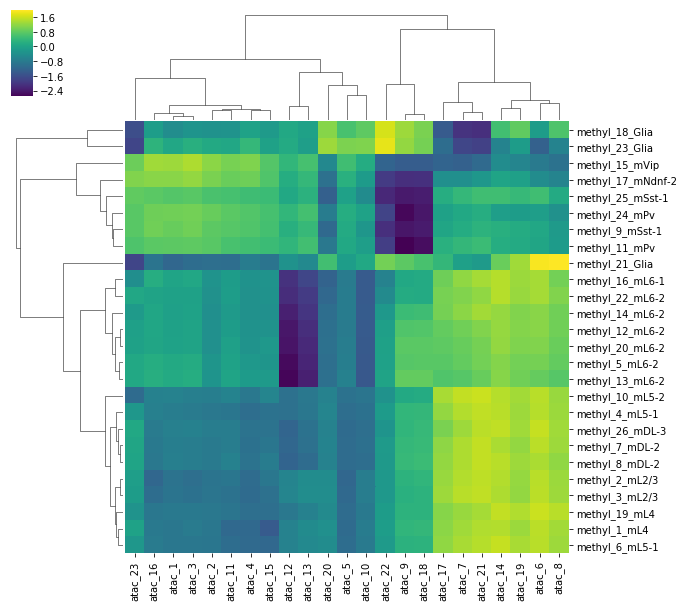

In [55]:
df_corr = pd.DataFrame(corr[nclst_atac:, :nclst_atac], index=data_mcc.columns, columns=data_atac.columns)
# df_corr = df_corr.T
reject_threshold = 1000

df_annot = pd.DataFrame(columns=df_corr.columns, index=df_corr.index)
for col, idx in df_corr.idxmin().iteritems():
    if df_corr.loc[idx, col] < reject_threshold:
        # print(col + ' --> ' + idx)
        df_annot.loc[idx, col] = '*'
    else:
        # print(col + ' cell type not matched!')
        pass
df_annot = df_annot.fillna('')

df_corr_zscore = df_corr.apply(zscore, axis=1)
df_annot_zscore = pd.DataFrame(columns=df_corr_zscore.columns, index=df_corr_zscore.index)
for col, idx in df_corr_zscore.idxmin().iteritems():
    if df_corr_zscore.loc[idx, col] < reject_threshold:
        # print(col + ' --> ' + idx)
        df_annot_zscore.loc[idx, col] = '*'
    else:
        # print(col + ' cell type not matched!')
        pass
df_annot_zscore = df_annot_zscore.fillna('')

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
ax = axs[0]
sns.heatmap(df_corr, annot=df_annot, fmt='', ax=ax, cmap='viridis')
ax = axs[1]
sns.heatmap(df_corr_zscore, annot=df_annot_zscore, fmt='', ax=ax, cmap='viridis')
fig.savefig('/cndd/fangming/integration/1.pdf')
plt.show()


sns.clustermap(df_corr_zscore, cmap='viridis')
plt.savefig('/cndd/fangming/integration/1-1.pdf')
plt.show()

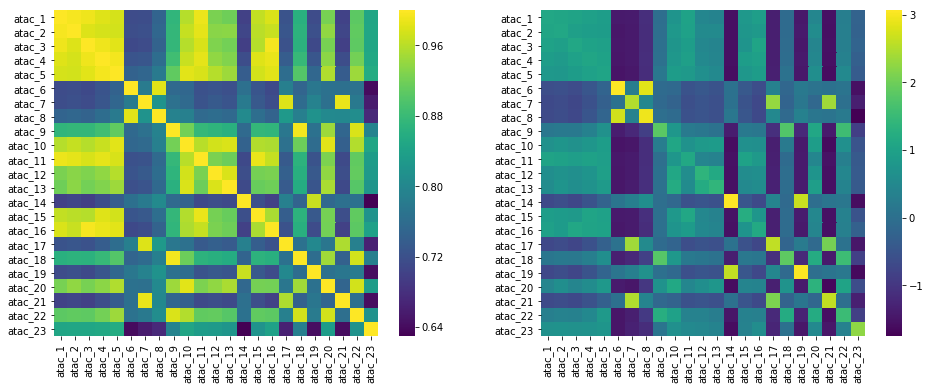

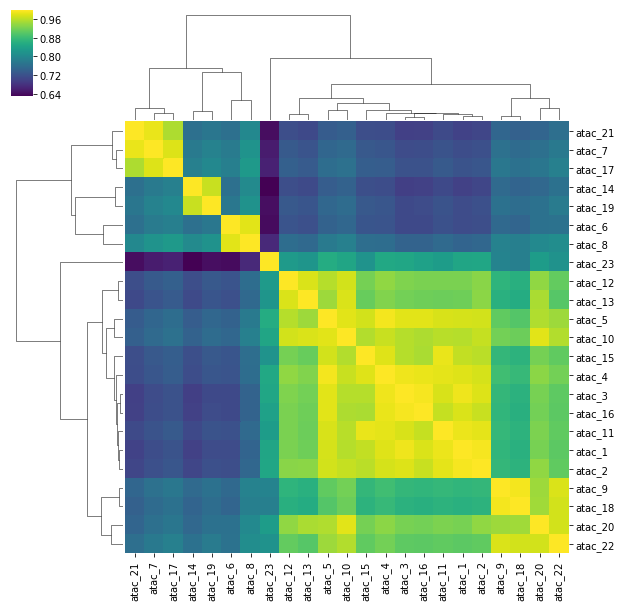

In [37]:
df_corr = pd.DataFrame(corr[:nclst_atac, :nclst_atac], index=data_atac.columns, columns=data_atac.columns)
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
ax = axs[0]
sns.heatmap(df_corr, ax=ax, cmap='viridis')
ax = axs[1]
sns.heatmap(df_corr.apply(zscore, axis=1), ax=ax, cmap='viridis')
fig.savefig('/cndd/fangming/integration/2.pdf')
plt.show()

sns.clustermap(df_corr, cmap='viridis', col_cluster=True)
plt.savefig('/cndd/fangming/integration/2-1.pdf')
plt.show()


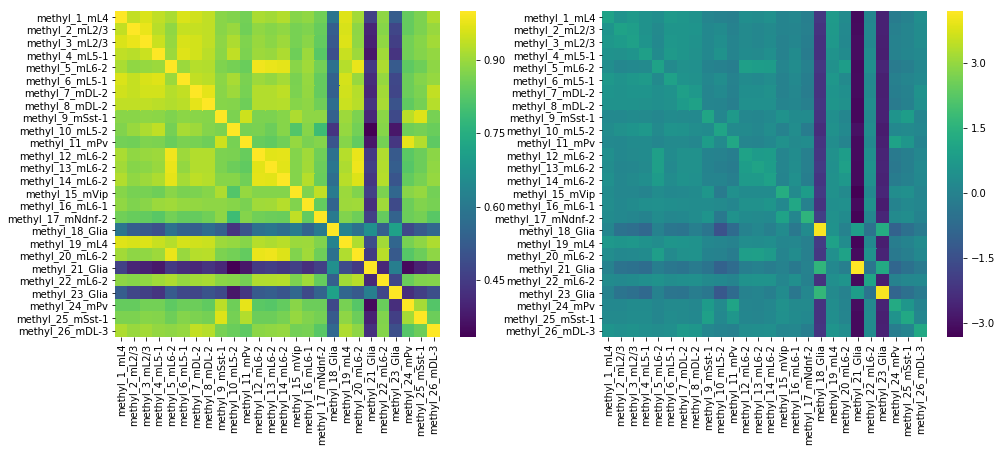

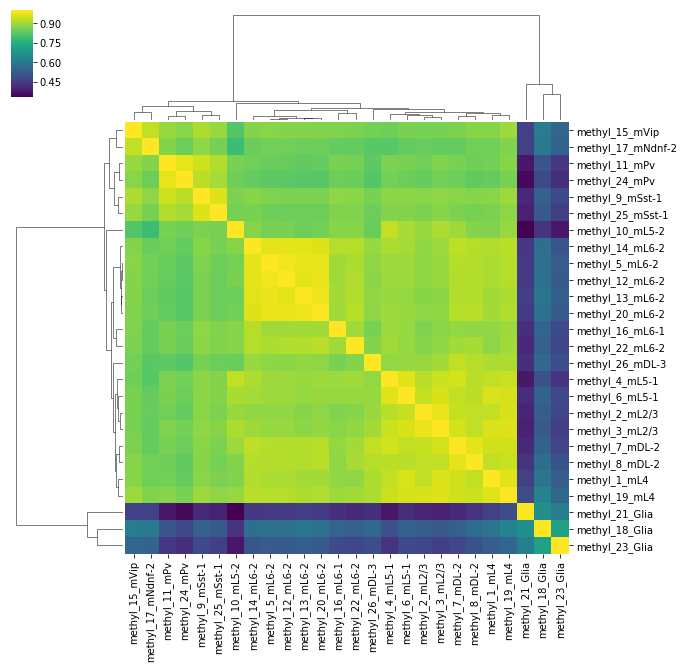

In [262]:
df_corr = pd.DataFrame(corr[nclst_atac:, nclst_atac:], index=data_mcc.columns, columns=data_mcc.columns)
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
ax = axs[0]
sns.heatmap(df_corr, ax=ax, cmap='viridis')
ax = axs[1]
sns.heatmap(df_corr.apply(zscore, axis=1), ax=ax, cmap='viridis')
fig.savefig('/cndd/fangming/integration/3.pdf')
plt.show()


sns.clustermap(df_corr, cmap='viridis', col_cluster=True)
plt.savefig('/cndd/fangming/integration/3-1.pdf')
plt.show()

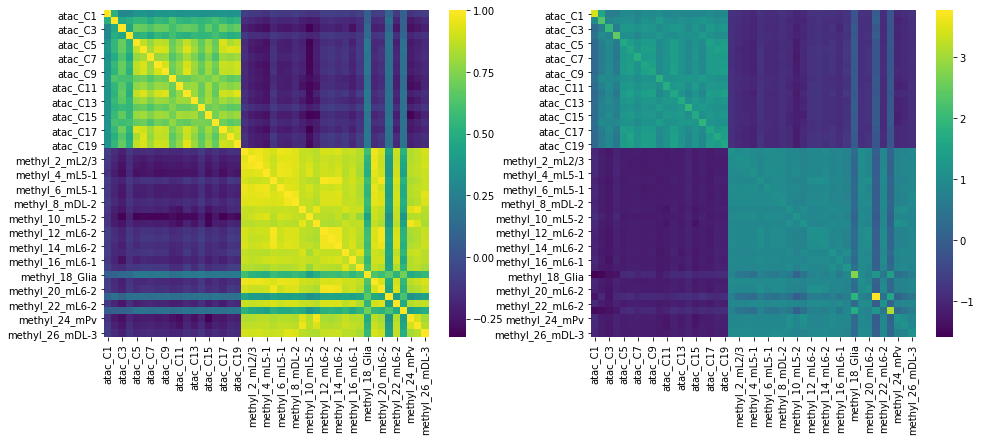

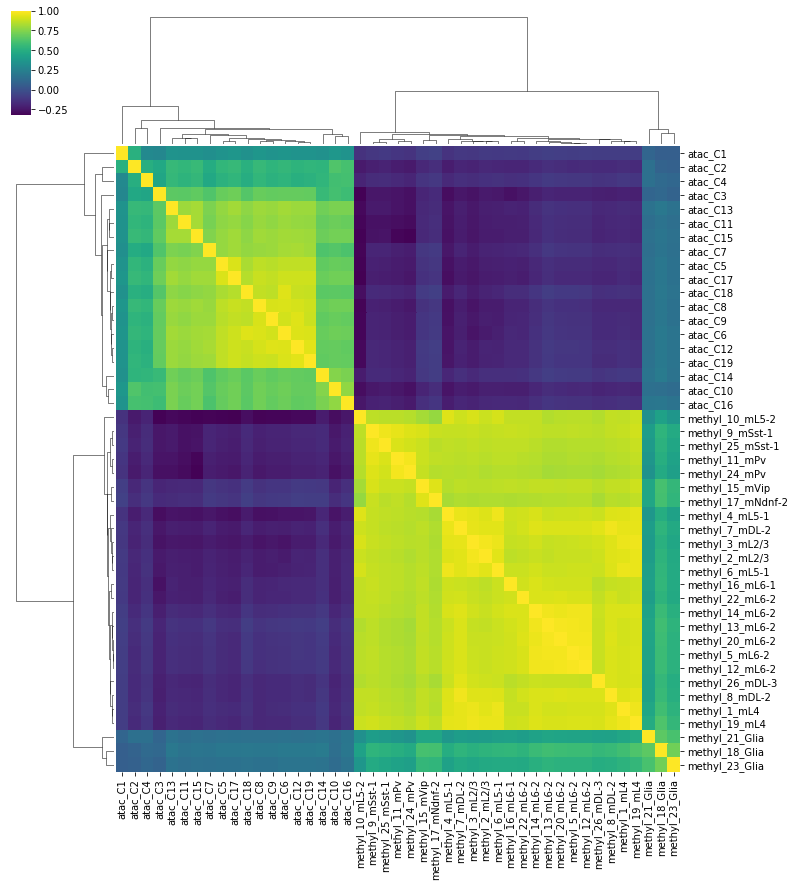

In [263]:
df_corr = pd.DataFrame(corr, 
                       index=data_atac.columns.tolist() + data_mcc.columns.tolist(),
                       columns=data_atac.columns.tolist() + data_mcc.columns.tolist())
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
ax = axs[0]
sns.heatmap(df_corr, ax=ax, cmap='viridis')
ax = axs[1]
sns.heatmap(df_corr.apply(zscore, axis=1), ax=ax, cmap='viridis')
fig.savefig('/cndd/fangming/integration/4.pdf')
plt.show()


sns.clustermap(df_corr, cmap='viridis', col_cluster=True, figsize=(12, 14))
plt.savefig('/cndd/fangming/integration/4-1.pdf')
plt.show()

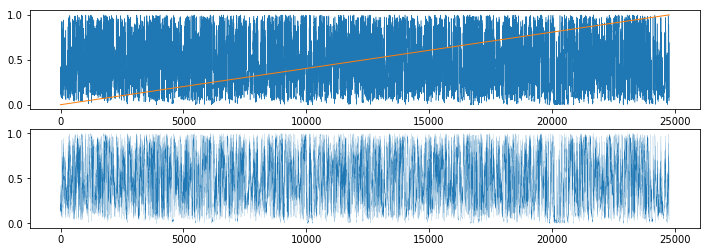

In [169]:
fig, axs = plt.subplots(2, 1, figsize=(12, 4))
ax = axs[0]
ax.plot(data_mcc['methyl_1'].values, linewidth=0.5)
ax.plot(data_mcc.loc[data_mcc['methyl_1'].sort_values().index, 'methyl_1'].values, linewidth=1)
ax = axs[1]
ax.plot(data_mcc['methyl_1'].values, linewidth=0.1)
plt.show()